In [1]:
import math
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.stats import norm, multivariate_normal


def covariance_ellipse(P, deviations=1):
    """
    Returns a tuple defining the ellipse representing the 2 dimensional
    covariance matrix P.
    Parameters
    ----------
    P : nd.array shape (2,2)
       covariance matrix
    deviations : int (optional, default = 1)
       # of standard deviations. Default is 1.
    Returns (angle_radians, width_radius, height_radius)
    """

    U, s, _ = np.linalg.svd(P)
    orientation = math.atan2(U[1, 0], U[0, 0])
    width = deviations * math.sqrt(s[0])
    height = deviations * math.sqrt(s[1])

    if height > width:
        raise ValueError('width must be greater than height')

    return (orientation, width, height)

def _std_tuple_of(var=None, std=None, interval=None):
    """
    Convienence function for plotting. Given one of var, standard
    deviation, or interval, return the std. Any of the three can be an
    iterable list.
    Examples
    --------
    >>>_std_tuple_of(var=[1, 3, 9])
    (1, 2, 3)
    """

    if std is not None:
        if np.isscalar(std):
            std = (std,)
        return std


    if interval is not None:
        if np.isscalar(interval):
            interval = (interval,)

        return norm.interval(interval)[1]

    if var is None:
        raise ValueError("no inputs were provided")

    if np.isscalar(var):
        var = (var,)
    return np.sqrt(var)

def plot_covariance(
        mean, cov=None, variance=1.0, std=None, interval=None,
        ellipse=None, title=None, axis_equal=True,
        show_semiaxis=False, show_center=True,
        facecolor=None, edgecolor=None,
        fc='none', ec='#004080',
        alpha=1.0, xlim=None, ylim=None,
        ls='solid'):
    """
    Plots the covariance ellipse for the 2D normal defined by (mean, cov)
    `variance` is the normal sigma^2 that we want to plot. If list-like,
    ellipses for all ellipses will be ploted. E.g. [1,2] will plot the
    sigma^2 = 1 and sigma^2 = 2 ellipses. Alternatively, use std for the
    standard deviation, in which case `variance` will be ignored.
    ellipse is a (angle,width,height) tuple containing the angle in radians,
    and width and height radii.
    You may provide either cov or ellipse, but not both.
    Parameters
    ----------
    mean : row vector like (2x1)
        The mean of the normal
    cov : ndarray-like
        2x2 covariance matrix
    variance : float, default 1, or iterable float, optional
        Variance of the plotted ellipse. May specify std or interval instead.
        If iterable, such as (1, 2**2, 3**2), then ellipses will be drawn
        for all in the list.
    std : float, or iterable float, optional
        Standard deviation of the plotted ellipse. If specified, variance
        is ignored, and interval must be `None`.
        If iterable, such as (1, 2, 3), then ellipses will be drawn
        for all in the list.
    interval : float range [0,1), or iterable float, optional
        Confidence interval for the plotted ellipse. For example, .68 (for
        68%) gives roughly 1 standand deviation. If specified, variance
        is ignored and `std` must be `None`
        If iterable, such as (.68, .95), then ellipses will be drawn
        for all in the list.
    ellipse: (float, float, float)
        Instead of a covariance, plots an ellipse described by (angle, width,
        height), where angle is in radians, and the width and height are the
        minor and major sub-axis radii. `cov` must be `None`.
    title: str, optional
        title for the plot
    axis_equal: bool, default=True
        Use the same scale for the x-axis and y-axis to ensure the aspect
        ratio is correct.
    show_semiaxis: bool, default=False
        Draw the semiaxis of the ellipse
    show_center: bool, default=True
        Mark the center of the ellipse with a cross
    facecolor, fc: color, default=None
        If specified, fills the ellipse with the specified color. `fc` is an
        allowed abbreviation
    edgecolor, ec: color, default=None
        If specified, overrides the default color sequence for the edge color
        of the ellipse. `ec` is an allowed abbreviation
    alpha: float range [0,1], default=1.
        alpha value for the ellipse
    xlim: float or (float,float), default=None
       specifies the limits for the x-axis
    ylim: float or (float,float), default=None
       specifies the limits for the y-axis
    ls: str, default='solid':
        line style for the edge of the ellipse
    """

    from matplotlib.patches import Ellipse
    import matplotlib.pyplot as plt

    if cov is not None and ellipse is not None:
        raise ValueError('You cannot specify both cov and ellipse')

    if cov is None and ellipse is None:
        raise ValueError('Specify one of cov or ellipse')

    if facecolor is None:
        facecolor = fc

    if edgecolor is None:
        edgecolor = ec

    if cov is not None:
        ellipse = covariance_ellipse(cov)

    if axis_equal:
        plt.axis('equal')

    if title is not None:
        plt.title(title)

    ax = plt.gca()

    angle = np.degrees(ellipse[0])
    width = ellipse[1] * 2.
    height = ellipse[2] * 2.

    std = _std_tuple_of(variance, std, interval)
    for sd in std:
        e = Ellipse(xy=mean, width=sd*width, height=sd*height, angle=angle,
                    facecolor=facecolor,
                    edgecolor=edgecolor,
                    alpha=alpha,
                    lw=2, ls=ls)
        ax.add_patch(e)
    x, y = mean
    if show_center:
        plt.scatter(x, y, marker='+', color=edgecolor)

    if xlim is not None:
        ax.set_xlim(xlim)

    if ylim is not None:
        ax.set_ylim(ylim)

    if show_semiaxis:
        a = ellipse[0]
        h, w = height/4, width/4
        plt.plot([x, x+ h*math.cos(a+np.pi/2)], [y, y + h*math.sin(a+np.pi/2)])
        plt.plot([x, x+ w*math.cos(a)], [y, y + w*math.sin(a)])

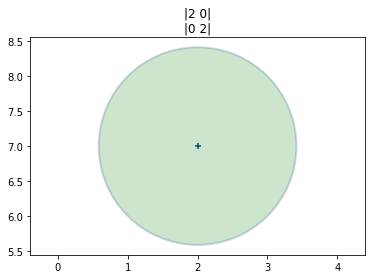

In [3]:
x = [2, 7]
P = [[2, 0], [0, 2]]
plot_covariance(x, P, fc='g', alpha=0.2,
                       title='|2 0|\n|0 2|')
plt.gca().grid(b=False)

In [4]:
def multivariate_multiply(m1, c1, m2, c2):
    """
    Multiplies the two multivariate Gaussians together and returns the
    results as the tuple (mean, covariance).
    Examples
    --------
    .. code-block:: Python
        m, c = multivariate_multiply([7.0, 2], [[1.0, 2.0], [2.0, 1.0]],
                                     [3.2, 0], [[8.0, 1.1], [1.1,8.0]])
    Parameters
    ----------
    m1 : array-like
        Mean of first Gaussian. Must be convertable to an 1D array via
        numpy.asarray(), For example 6, [6], [6, 5], np.array([3, 4, 5, 6])
        are all valid.
    c1 : matrix-like
        Covariance of first Gaussian. Must be convertable to an 2D array via
        numpy.asarray().
     m2 : array-like
        Mean of second Gaussian. Must be convertable to an 1D array via
        numpy.asarray(), For example 6, [6], [6, 5], np.array([3, 4, 5, 6])
        are all valid.
    c2 : matrix-like
        Covariance of second Gaussian. Must be convertable to an 2D array via
        numpy.asarray().
    Returns
    -------
    m : ndarray
        mean of the result
    c : ndarray
        covariance of the result
    """

    C1 = np.asarray(c1)
    C2 = np.asarray(c2)
    M1 = np.asarray(m1)
    M2 = np.asarray(m2)

    sum_inv = np.linalg.inv(C1+C2)
    C3 = np.dot(C1, sum_inv).dot(C2)

    M3 = (np.dot(C2, sum_inv).dot(M1) +
          np.dot(C1, sum_inv).dot(M2))

    return M3, C3

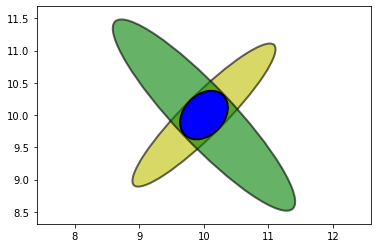

In [6]:
P0 = [[6, 0], [0, 6]]
P1 = [[2, 1.9], [1.9, 2]]
P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
P3 = [[2, -1.9], [-1.9, 2.2]]
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance((10, 10), P2, ec='k', fc='y', alpha=0.6)
plot_covariance((10, 10), P3, ec='k', fc='g', alpha=0.6)
plot_covariance((10, 10), P4, ec='k', fc='b')